In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from sklearn.model_selection import *

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# TPOT python auto ml
# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)

mm
a= None

## data folder set up and test

In [4]:
dataFolder = 'data/mainData_original/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(idd):
    id = str(idd)
    
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
def drawOneGalaxy(galaxyID, preProc=0):
    oneImageData = read_image(galaxyID)
    if ( preProc != 0):
        oneImageData = img_preprocnoread(oneImageData,preProc)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

# for _ in range(5):
#     i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
#     drawOneGalaxy(dataFileList[i])
    


In [7]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

# ML part

In [8]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [9]:
BlackHighThreshold = 0.1 # the definition of 'black' to determine the radius of a non galaxy object, in luminance
PeakExclusionRadius = 0.1 # the radius around the center within which we ignore luminosity peaks, expressed as an image percentage
NonClearingRadius = 0.1 # the radius around the center within which we don't clean (even with peaks outside)
ObjectLuminosityPercentage = 0.7 # the peak luminosity threshold that we remove points around, expressed as a percentage of the peak center luminosity
valueWhenRemovingPixel = 0 # -55 when debugging, 0 when running

def removeNegs(A):
    for i in range(len(A)):
        for j in range(len(A)):
            A[i][j] = max(0,A[i][j])

    return A

def normalizeInt(A):
    ma = np.amax(A)
    mi = np.amin(A)

    A = A * (ma - mi)
    return A

def removePeakAtPosition(data, x, y, size):
    global BlackHighThreshold
    global valueWhenRemovingPixel
    imagewidth = len(data)
    center = imagewidth/2

    threshold = BlackHighThreshold #definition of "black"
    exlusionRadiusSquared = (imagewidth*PeakExclusionRadius)**2  # radius around the center where we don't remove anything
    for i in range(imagewidth):
        if (
                ( x-i >= 0 and data[x-i][y] < threshold) or
                ( x+i < imagewidth and data[x+i][y] < threshold ) or
                ( y -i >= 0 and data[x][y-i] < threshold ) or
                ( y +i < imagewidth and data[x][y+i] < threshold )
            ):
            circlesize = i
            break

    for i in range(x-circlesize, x+circlesize+1):
        for j in range(y-circlesize, y+circlesize+1):
            if ( i >= 0 and i < len(data[1]) and
                 i >= 0 and j < len(data[1]) and
                     (x-i)**2 + (y-j)**2 <= circlesize**2):
                # exlusion zone
                if ( (center-i)**2 + (center-j)**2 >= exlusionRadiusSquared ):
                    data[i][j] = valueWhenRemovingPixel

    return data

def removeAboveThreshold(A, threshold):
    global valueWhenRemovingPixel
    for i in range(len(A)):
        for j in range(len(A)):
            if ( A[i][j] > threshold ):
                A[i][j] = valueWhenRemovingPixel

    return A

def findLumCenter(A):
    center = int(len(A)/2)

    peakfound = False
    moved = False
    px = center
    py = center
    while True:
        moved = False
        for i in range(-5, 5):
            for j in range(-5, 5):
                if (A[px + i][py + j] > A[px][py]):
                    px = px + i
                    py = py + j
                    moved = True
                    break
        if (moved == False):
            peakfound = True
            break

    if (peakfound == True):
        centerLum = A[px][py]

    return centerLum

def findMaxima(A):
    global NonClearingRadius
    global ObjectLuminosityPercentage
    width = len(A)
    center = int(width / 2)

    #find lum center
    centerLum = findLumCenter(A)

    starLumThreshold = centerLum * ObjectLuminosityPercentage
    exlusionRadiusSquared = (width*NonClearingRadius)**2


    for x in range(width):
        for y in range(width):
            # find the peak:
            if A[x][y] <= starLumThreshold:
                continue
            # found a place where there's a peak. Find it
            peakfound = False
            moved = False
            px = x
            py = y
            while True:
                moved = False
                for i in range(-2,2):
                    for j in range(-2,2):
                        if ( px+i < 1 or py+j < 1 or px+i >= width or py+j >= width):
                            continue

                        if (A[px + i][py + j] > A[px][py]):
                            px = px + i
                            py = py + j
                            moved = True
                            break
                if (moved == False):
                    peakfound = True
                    break

            if (peakfound == True):
                # remove that peak
                if ((center - px) ** 2 + (center - py) ** 2 > exlusionRadiusSquared):
                    A = removePeakAtPosition(A,px,py,max(abs(py-y),abs(px-x))+1)
#            print("found", (px, py), (x, y))

    return A

def cleanupImage(A):
    A = removeNegs(A)
    A = findMaxima(A)
    A = removeAboveThreshold(A, findLumCenter(A))
    return A

In [10]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def scale_image(A):
    A = (A - A.min()) / (A.max()-A.min())
    return A

def normalize_image(A):
    A -= np.mean(A)
    A /= np.std(A)
    
    return A

def crop_image(Xg, percentage=0.75):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = int(cy*percentage), int(cx*percentage) # crop a bit around center
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg, preProcNum = 0):
    Xg = cleanupImage(Xg)

    if preProcNum & 1: # vflip
        Xg = np.flip(Xg,0)
    if preProcNum & 2: # hflip
        Xg = np.flip(Xg,1)
    if preProcNum & 4: # rotate
        Xg = np.rot90(Xg)
    if preProcNum & 16: 
        Xg = scale_image(Xg)
        
    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    
    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id, preProcNum = 0):
    Xg = read_image(id)
    return img_preprocnoread(Xg,preProcNum)

runNameParams.append('ReadLog1pNormCrop.75origOldCleanup')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')


### Read metadata file

In [11]:
df =  pd.read_fwf('metaData.dat', comment = '#')

df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)
df['ML_g'] = df['ML_g'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+str(x)+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

data file present: 80306
data file missing: 107436


,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,1.877420e+05,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,1.237661e+18,184.527190,24.898677,0.445798,0.074652,38.318105,319.936358,0.620438,1.344514e+02,2.276347e+02,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,6.148370e+12,61.620064,19.374103,0.168006,0.040143,18.942158,172.041273,0.333632,3.042135e+04,4.315111e+04,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,1.237646e+18,0.008250,-11.252830,0.316228,0.010000,4.034125,42.857142,0.083111,0.000000e+00,0.000000e+00,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,1.237657e+18,152.349938,8.662357,0.346737,0.044100,25.157782,189.000006,0.366519,1.510054e+00,1.671007e+00,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,1.237662e+18,185.824575,23.197910,0.389045,0.069000,35.525868,295.714278,0.573465,2.795371e+00,2.384652e+00,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,1.237665e+18,222.151537,39.835143,0.478630,0.096400,48.283920,413.142858,0.801189,3.940449e+00,2.978691e+00,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,1.237681e+18,359.994900,70.133250,10.964781,0.299600,1373.931687,1284.000022,2.490003,1.034487e+07,1.346961e+07,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


### Filter images that have no known mass, no actual image, or with an unknown error

In [12]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df = df[df.Distance < 600]
df = df[df.ML_g < 15]

df = df[~df['SDSS_ID'].isin(['1237668349209149549','1237662224593846425','1237648705129283884','1237648703514804436'])] # remove 2 buggy galaxies
  
df['ML_g_rel_err'] = df['ML_g_rel_err'].apply(np.float64)

df = df[df['ML_g_rel_err'] != 0]

df.describe()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,ML_g_rel_err,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,7.690800e+04,76908.000000,76908.000000,76908.000000,76908.000000,76908.000000,76908.000000,76908.000000,76908.000000,76908.000000,76908.000000,76908.000000,76908.000000,76908.000000,7.690800e+04,7.690800e+04
mean,1.237661e+18,185.363384,25.591045,0.559936,0.055999,36.636410,239.994706,0.465411,2.699361,15.806861,0.562392,10.536321,0.031146,239.994706,7.263293e+10,4.062556e+09
std,5.869278e+12,57.113914,18.945129,0.194567,0.027703,16.779334,118.729089,0.230246,1.475122,3377.629673,102.384367,0.645861,0.016757,118.729089,8.163383e+10,4.870111e+09
min,1.237646e+18,0.013950,-11.238420,0.407380,0.010000,5.248929,42.857142,0.083111,0.025804,0.065665,0.003646,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,1.237658e+18,154.562887,9.698530,0.436516,0.033500,24.118150,143.571432,0.278422,1.536113,1.700773,0.048811,10.182000,0.019000,143.571432,1.520548e+10,9.922044e+08
50%,1.237662e+18,186.820050,24.302440,0.501187,0.051300,34.510212,219.857145,0.426359,2.666394,2.314526,0.070016,10.673000,0.028000,219.857145,4.709773e+10,2.595871e+09
75%,1.237665e+18,222.051337,40.008845,0.602560,0.073800,46.362873,316.285704,0.613359,3.581785,2.833272,0.100170,11.007000,0.039000,316.285704,1.016249e+11,5.312598e+09
max,1.237680e+18,359.994900,70.133250,10.964781,0.139900,828.365356,599.571424,1.162722,14.982426,934654.964691,28211.488702,12.109000,0.222000,599.571424,1.285287e+12,9.006282e+10


In [13]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,ML_g_rel_err,ML_i_rel_err,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
174,1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,2.472975,2.279201,0.105385,0.10490392881262686,10.325,0.045,326.142854,2.113489e+10,2.189920e+09,True
216,1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.841365,1.148099,0.093758,0.09498951605786418,9.824,0.040,293.571417,6.668068e+09,6.141517e+08,True
237,1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.703785,1.051369,0.122754,0.12327084107474802,9.923,0.053,167.142861,8.375293e+09,1.022096e+09,True
276,1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.248502,1.269311,0.183377,0.1837691489095808,10.356,0.079,282.000016,2.269865e+10,4.128980e+09,True
332,1237662474232398001,246.28905,29.94774,0.446684,0.0455,25.337321,194.999996,0.378155,0.419816,0.559744,0.219920,0.2194701990290622,9.234,0.094,194.999996,1.713957e+09,3.709741e+08,True


In [14]:
print(len(df.SDSS_ID.values))

76908


In [15]:
vgg16 = None
r50 = None
cnn = None

In [16]:
postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']
distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]
numFeatures = 0

def getFeatures(preProcessingNum):
    global vgg16, r50, cnn,numFeatures
    
    if vgg16 == None:
        vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
    if r50 == None:
        r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
#     if cnn == None:
#         cnn = load_model('encoder.h5')
    Xg3r50 = []
    Xg3vgg16 = []
    postImgFeatures = []
    csize=2
    preImgFeatures = []
    cnnFeatures = []

    maxChunkNumber = math.ceil(len(ids)/chunkSize)
    chunkStart = 0
    # for chunkStart in tqdm(range(0, 3)):
    
    # do the loading by chunk to avoid consuming too much memory
    for chunkStart in tqdm(range(0, len(ids), chunkSize)):
        curChunk = int((chunkStart//chunkSize))
        valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

        Xg_ = []
        pre_ex_ = []

        # preprocess the image and collect some raw image stats
        for i in range(chunkStart, chunkStart+valuesInThisChunk):
            X = read_image(ids[i])
            Xg_.append(img_preprocnoread(X, preProcessingNum))
            pre_ex_.append([
                X.sum(),
                X.min(),
                X.max(),
                X.mean(),
                X.std(),
                X[X.shape[0]//2,X.shape[1]//2],
                np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
                X.shape[0], 
            ])

        # stack the postprocessing
        pre_ex = np.stack(pre_ex_)
        Xg = np.stack(Xg_)

        # collect some post processing stats
        post_ex = np.hstack([
            np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
            np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
            ])

        
#         cnnFeatures_ = cnn.predict( Xg[:,:,:,newaxis])
#         cnnFeatures_ = cnnFeatures.reshape(valuesInThisChunk, -1)
        
        # prepare correct dimension to feed to imagenet networks
        Xg3 = np.zeros((valuesInThisChunk,224,224,3))
        Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)

        # do r50 prediction
        Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
        Xg3vgg16_ = vgg16.predict(Xg3)
        


        if chunkStart == 0:
            Xg3r50 = Xg3r50_
            Xg3vgg16 = Xg3vgg16_
            preImgFeatures = pre_ex
            postImgFeatures = post_ex
#             cnnFeatures = cnnFeatures_
        else:
            Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
            Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
            preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
            postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)
#             cnnFeatures = np.concatenate([cnnFeatures, cnnFeatures_], axis = 0)


    # add features from the data itself (distance)
    Distance = df.Distance.values[:N].reshape(N,1)

    Xg3f = np.hstack ( ( 
            Xg3r50, 
            Xg3vgg16, 
#             cnnFeatures,
            Distance,
            1/Distance,
            Distance**2,
            1/(Distance**2),
            Distance**3,
            1/(Distance**3),
            np.log(Distance),
            1/np.log(Distance),
            np.log(Distance**2),
            1/np.log(Distance**2),
            np.log(Distance)**2,
            1/np.log(Distance)**2,
            preImgFeatures,
            postImgFeatures
            ) )


    Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
                + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
#                 + [prefixThisRound+'.cnn.' + str(i) for i in range(cnnFeatures.shape[1])] 
                + [prefixThisRound+'.'+ n for n in distanceNames]
                + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
                + [prefixThisRound+'.'+ n for n in postImgFeatureNames])
    return Xg3f, Xg3fNames

# numFeatures = 2048 + 1000 + 7*7 *8 + len(postImgFeatureNames) + len(preImgFeatureNames) + len(distanceNames) 
numFeatures = 2048 + 1000 + len(postImgFeatureNames) + len(preImgFeatureNames) + len(distanceNames) 

    

In [17]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [18]:
def lgb_chi2(Yp, train_data):
    Y = train_data.get_label()
    err = 1/train_data.get_weight()**0.5
    return 'Chi²', round(xi2(Y,Yp,err),1), False


In [19]:
def getLGBMModelsWithCV(trainSet, YSet, errSet, errlinSet):
    kf = KFold(n_splits=nSplits,shuffle=True, random_state=220477)

    cvtrainpreds = np.zeros([len(Xg3f),nSplits])
    models = []
    counter = 0
    for tix, vix in kf.split(trainSet):
        X_train, X_test = trainSet[tix], trainSet[vix]
        Y_train, Y_test = YSet[tix], YSet[vix]

        lgb_train = lgbm.Dataset(X_train, Y_train)
        lgb_eval = lgbm.Dataset(X_test, Y_test)

        lgb_train.set_weight(1/train_err**2)
        lgb_eval.set_weight(1/test_err**2)
        
        gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=maxBoostRuns,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=100,
                        feval = lgb_chi2
                        )
        models.append(gbm)

        p = gbm.predict(X_test)

        cvtrainpreds[vix,counter] = p
        counter = counter+1
        
    return models, cvtrainpreds

# models, cvtrainpreds, xis, linxis = getModels(Xg3f[:M], Y[:M])

# print(models, cvtrainpreds)

# print(xis, linxis)


In [20]:
def getLGBMModelsNoCV(trainSet, YSet, errSet, errlinSet):
    cvtrainpreds = np.zeros([len(trainSet),1])
    models = []
    counter = 0

    tix, vix = list(range(0,int(len(trainSet)*0.9))), list(range(int(len(trainSet)*0.9),len(trainSet)))
    
    X_train, X_test = trainSet[tix], trainSet[vix]
    Y_train, Y_test = YSet[tix], YSet[vix]

    lgb_train = lgbm.Dataset(X_train, Y_train)
    lgb_eval = lgbm.Dataset(X_test, Y_test)

    lgb_train.set_weight(1/errSet[tix]**2)
    lgb_eval.set_weight(1/errSet[vix]**2)

    gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=maxBoostRuns,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=100,
                        feval = lgb_chi2
                     
                    )
    models.append(gbm)

    p = gbm.predict(X_test)
    cvtrainpreds[vix,counter] = p
    counter = counter+1
        
    return models, cvtrainpreds


In [21]:
TRAIN = 0
TEST = 4

FEATURES = 0
TRUTH = 1
ERROR = 2
LINERROR = 3

ID = 8
FEATURENAMES = 9

data = list(range(10))


In [22]:
# breakqsdqsd

# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [23]:
df = df.sample(frac=1)

In [24]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)

prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

prefixThisRound = prefixThisRound + '-model11'
    
chunkSize = 200
# nSplits = 3
reloadImagesAndPreprocess = 0
numPreprocessing = 1
nSplits = 1

maxBoostRuns = 30000 # 30000
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout
# N = int(N*0.1)
# M = int(M*0.1)


# N = int(N*0.01)
# M = int(M*0.01)


In [25]:
df.columns

Index(['SDSS_ID', 'RA', 'DEC', 'D25', 'redshi', 'GalSize_kpc', 'D_Mpc',
       'd_pix_kpc', 'ML_g', 'ML_i', 'ML_g_rel_err', 'ML_i_rel_err', 'logMstar',
       'err_logMstar', 'Distance', 'lin_mass', 'lin_err', 'hasFile'],
      dtype='object')

In [26]:
# plt.figure(figsize=(18,8))
# plt.subplot(121)
# plt.xlabel('ML_g')
# plt.ylabel('log(M)')
# sns.kdeplot(x=df.ML_g, y=df.logMstar, alpha=0.2)
# plt.subplot(122)
# plt.hist(x=df.ML_g, bins=100)
# plt.title('ML_g histogram')
# plt.xlabel('ML_g')
# 1

In [27]:
ids = df.SDSS_ID.values[:N]
#Y = df.logMstar.values[:N]
Y = df.ML_g.values[:N]
err = df.ML_g_rel_err.values[:N] * Y
# Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [28]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

76908
69217
200
sp-newSource-ReadLog1pNormCrop.75origOldCleanup-model11


In [29]:
ttaPredictions = np.zeros([numPreprocessing,nSplits,N-M])


data[TRAIN+FEATURES] = np.ones([0,numFeatures])
data[TRAIN+TRUTH] = np.ones([0])
data[TRAIN+ERROR] = np.ones([0])
data[TRAIN+LINERROR] = np.ones([0])
data[TEST+FEATURES] = np.ones([0,numFeatures])
data[TEST+TRUTH] = np.ones([0])
data[TEST+ERROR] = np.ones([0])
data[TEST+LINERROR] = np.ones([0])

fileName = prefixThisRound + '-' + str(N) + 'allFeatures' + str(numPreprocessing) + '.npy'

data[ID] = ids

if reloadImagesAndPreprocess == 1 or not(os.path.isfile(fileName)):
    for curTTA in range(numPreprocessing):
        a, Xg3fNames = getFeatures(curTTA+16) # 16 for rescale

        data[TRAIN+FEATURES] = np.vstack([data[TRAIN+FEATURES],a[:M]])
        data[TRAIN+TRUTH] = np.hstack([data[TRAIN+TRUTH],Y[:M]])
        data[TRAIN+ERROR] = np.hstack([data[TRAIN+ERROR],err[:M]])
        data[TRAIN+LINERROR] = np.hstack([data[TRAIN+LINERROR], err_lin[:M]])

        data[TEST+FEATURES] = np.vstack([data[TEST+FEATURES],a[M:]])
        data[TEST+TRUTH] = np.hstack([data[TEST+TRUTH],Y[M:]])
        data[TEST+ERROR] = np.hstack([data[TEST+ERROR],err[M:]])
        data[TEST+LINERROR]  = np.hstack([data[TEST+LINERROR] , err_lin[M:]])

    np.save(fileName, data)
else:
    data = np.load(fileName)


print("loaded")

100%|██████████| 385/385 [2:31:14<00:00, 21.94s/it]  


loaded


In [30]:
# data.append(Xg3fNames)
# print(len(data))
# np.save(fileName, data)

In [31]:
from keras.models import load_model

In [32]:
models, cvtrainpreds = getLGBMModelsNoCV(data[TRAIN+FEATURES], data[TRAIN+TRUTH], data[TRAIN+ERROR], data[TRAIN+LINERROR])

ppreds = np.zeros([len(models),data[TEST+FEATURES].shape[0]])
for i, m in zip(range(len(models)),models):
    mp = m.predict(data[TEST+FEATURES])
    ppreds[i] = mp

cvpred = ppreds.mean(axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.862689	training's Chi²: 86.1	valid_1's rmse: 0.878619	valid_1's Chi²: 80.5
[200]	training's rmse: 0.618324	training's Chi²: 44.2	valid_1's rmse: 0.690873	valid_1's Chi²: 49.8
[300]	training's rmse: 0.553712	training's Chi²: 35.5	valid_1's rmse: 0.642067	valid_1's Chi²: 43
[400]	training's rmse: 0.528289	training's Chi²: 32.3	valid_1's rmse: 0.623684	valid_1's Chi²: 40.6
[500]	training's rmse: 0.51366	training's Chi²: 30.5	valid_1's rmse: 0.615029	valid_1's Chi²: 39.5
[600]	training's rmse: 0.502956	training's Chi²: 29.3	valid_1's rmse: 0.608894	valid_1's Chi²: 38.7
[700]	training's rmse: 0.494641	training's Chi²: 28.3	valid_1's rmse: 0.60483	valid_1's Chi²: 38.2
[800]	training's rmse: 0.487656	training's Chi²: 27.5	valid_1's rmse: 0.601485	valid_1's Chi²: 37.7
[900]	training's rmse: 0.481473	training's Chi²: 26.8	valid_1's rmse: 0.599354	valid_1's Chi²: 37.5
[1000]	training's rmse: 0.476016	training

In [33]:
print("Iteration : {}".format(numPreprocessing))
print("rmse of log(M):",rmse(data[TEST+TRUTH],cvpred))

# ttaPredictions[curTTA] = ppreds
    

Iteration : 1
rmse of log(M): 1.02860230052


In [34]:
ppreds.reshape((numPreprocessing,-1)).mean(axis=0)

array([ 2.54204391,  1.54854606,  0.8930602 , ...,  1.58105904,
        2.85445214,  4.02222139])

In [35]:
# print(M)
# print(trainXg3fStacked.shape)
# testXg3fStacked.shape
# ttaPredictions.shape
# ppreds.shape

mpred = ppreds.reshape((numPreprocessing,-1)).mean(axis=0)
print("Iteration : {}".format(numPreprocessing))
print("rmse of log(M):",rmse(data[TEST+TRUTH],mpred))


Iteration : 1
rmse of log(M): 1.02860230052


(7691,)
30.7400948373


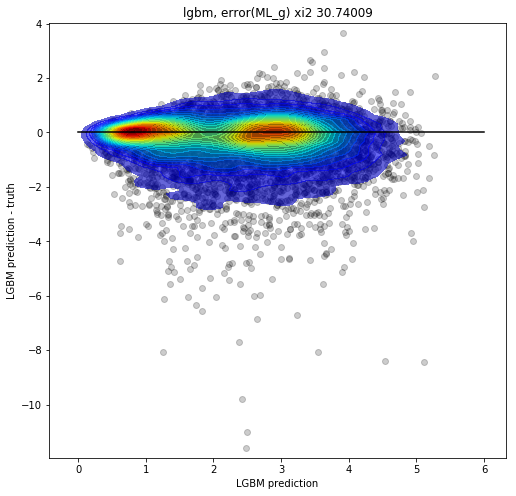

In [36]:
print(mpred.shape)
xx = xi2(mpred, data[TEST+TRUTH],data[TEST+ERROR])
print(xx)
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('lgbm, error(ML_g) xi2 {:0.5f}'.format(xx) )
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.2, c='k')
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet', alpha=0.6)
plt.xlabel('LGBM prediction')
plt.ylabel('LGBM prediction - truth')
plt.plot([0,6],[0,0], 'k-')


In [37]:
import keras


In [38]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    epochsPerDraw = 10
    referencePrediction = None
    
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.test_losses = [] # external validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        self.lasttrainplot = None
        self.lasttestplot = None
        
    def on_train_begin(self, logs={}):
        self.initVars()
        self.referenceLoss = xi2(self.referencePrediction, data[TEST+TRUTH], data[TEST+ERROR])

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        currentLearningRate = K.get_value(model.optimizer.lr)
        self.lr.append(currentLearningRate)

        if ( self.i %self.epochsPerDraw != 0 ):
            return

        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.suptitle("{}/{} {} {}".format(self.i, numEpochs, curloss, prefixThisRound))
        
#         ax = plt.subplot(131) # self values
#         if self.lasttrainplot == None or self.i %self.epochsPerDraw == 0:
#             self.plotSelfTrain(ax)
#         else:
#             ax = self.lasttrainplot

        ax = plt.subplot(121)
        if self.lasttestplot == None or self.i %self.epochsPerDraw == 0:
            self.plotSelfTest(ax)
        else:
            ax = self.lasttestplot
    
        ax = plt.subplot(122)
        self.plotLosses(ax)
        

        plt.savefig("pltsave/" + prefixThisRound + "%05d.png" % self.i)
        plt.show();
    
    def plotSelfTrain(self, ax):

        pred = model.predict(data[TRAIN+FEATURES])[:,0]
#         r = rmse(pred,data[TRAIN+TRUTH])
        r = xi2(pred,data[TRAIN+TRUTH], data[TRAIN+ERROR])
        plt.scatter(x=data[TRAIN+TRUTH], y=pred, c='k', alpha=.1, label="NN train {:.2f}".format(r))
#         sns.kdeplot(data[TRAIN+TRUTH], pred,n_levels=10, shade=True, shade_lowest=False, cmap='rainbow', alpha=0.7)
        plt.xlabel('ML_g truth')
        plt.ylabel('prediction')
#         plt.plot([7, 13], [0,0], 'k-', lw=2, label="target")
#         axes = plt.gca()
#         axes.set_xlim([7,13])
        plt.legend()
        self.lasttrainplot = ax
    
    def plotSelfTest(self, ax):
        
        # lgbm values
        plt.scatter(x=data[TEST+TRUTH], 
                    y=self.referencePrediction, 
                    c='b', alpha=.1, label="ref {:02f}".format(self.referenceLoss))
        
        # test values
        pred = model.predict(data[TEST+FEATURES])[:,0]
        r = xi2(pred,data[TEST+TRUTH], data[TEST+ERROR])
        plt.scatter(x=data[TEST+TRUTH], y=pred, c='g', alpha=.1, label="NN test {:.2f}".format(r))
        plt.xlabel('ML_g truth')
        plt.ylabel('prediction')
        plt.plot([0, 12], [0, 12], 'k-', lw=2, label="target")
#         axes = plt.gca()
#         axes.set_xlim([7,13])
        plt.legend()
        self.lasttestplot = ax

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="val loss")
        ax.set_yscale("log", nonposy='clip')
        ax.axhline(self.referenceLoss,linestyle='--')
        plt.legend()
        ax2 = ax.twinx()
        ax2.set_yscale('log')
        plt.plot(self.x,self.lr, c='r', label='learning rate', alpha=0.8)
        
#         plt.plot(self.x, self.testrmse, label="test rmse", c='g')
        plt.legend()

        
plot_losses = PlotLosses()

In [39]:
import models


In [40]:
print(data[TRAIN+FEATURES].shape)
print(data[TRAIN+TRUTH].shape)

(69217, 3075)
(69217,)


In [41]:
print(set(np.argwhere(np.isnan(data[TRAIN+FEATURES]))[:,1]))
print(set(np.argwhere(np.isnan(data[TEST+FEATURES]))[:,1]))

set()
set()


In [42]:
# import keras.backend as K

# def KChi2(y_true, y_pred):
#     return K.mean((y_true-y_pred)**2)

# def Krmse(y_true,y_pred):
#     return keras.losses.mean_squared_error(y_true, y_pred)**0.5

# opt=RMSprop(lr=0.001)

# model.compile(optimizer=opt,
#              #loss=‘mean_squared_error’,
#              loss = KChi2,import keras.backend as K

#              #metrics=[KChi2,Krmse]
#             )


# model.fit(X_train,Y_train,
#          validation_data = (X_test,Y_test,1/test_err**2),
#          batch_size = 128,
#          verbose =1 , epochs = 10,
#          sample_weight = 1/train_err**2
#         )

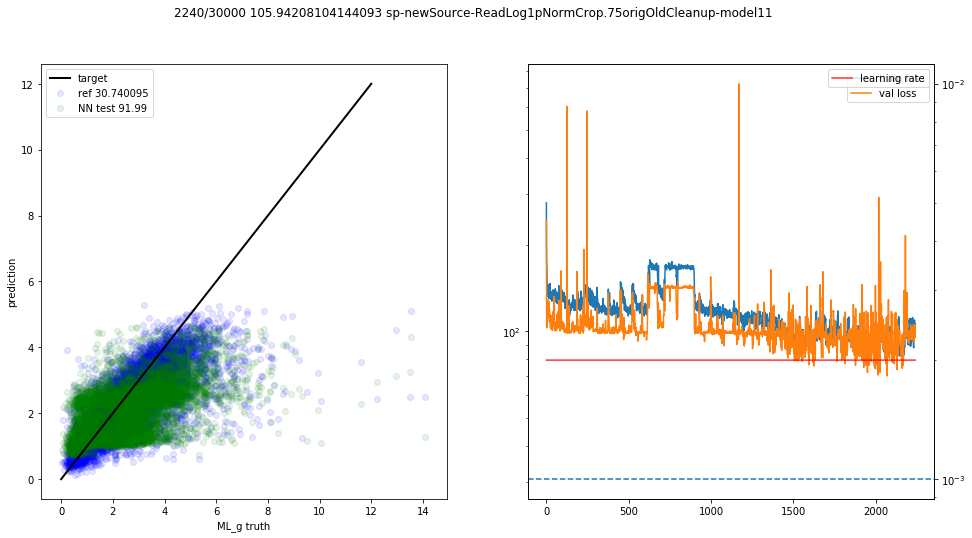

62295/62295 [==============================] - 1s - loss: 105.9421 - val_loss: 96.2407
Epoch 2241/30000
62295/62295 [==============================] - 0s - loss: 101.5530 - val_loss: 95.6396
Epoch 2242/30000
62295/62295 [==============================] - 0s - loss: 102.7649 - val_loss: 94.9813
Epoch 2243/30000
62295/62295 [==============================] - 0s - loss: 98.9721 - val_loss: 95.5379
Epoch 2244/30000
62295/62295 [==============================] - 0s - loss: 97.5160 - val_loss: 103.0665
Epoch 2245/30000
62295/62295 [==============================] - 0s - loss: 97.9376 - val_loss: 101.1501
Epoch 2246/30000
62295/62295 [==============================] - 0s - loss: 98.9222 - val_loss: 111.0794
Epoch 2247/30000
62295/62295 [==============================] - 0s - loss: 90.1180 - val_loss: 97.3424
Epoch 2248/30000
62295/62295 [==============================] - 0s - loss: 93.7995 - val_loss: 114.0845
Epoch 2249/30000
62295/62295 [==============================] - 0s - loss: 97.8101 

KeyboardInterrupt: 

In [54]:
# test keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.optimizers import *

model = Sequential()

model.add(Dense(500, input_shape=(data[TRAIN+FEATURES].shape[1],), activation = 'relu', kernel_initializer='truncated_normal',))
# model.add(Dropout(0.5))

model.add(Dense(300, activation='relu',kernel_initializer='truncated_normal',))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu',kernel_initializer='truncated_normal',))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='elu',kernel_initializer='truncated_normal'))

model.compile(optimizer='nadam', loss='mse')


reduceLRcallback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=500, verbose=0, mode='auto', epsilon=0.0001, cooldown=20, min_lr=1e-8)

numEpochs = 30000
plot_losses.epochsPerDraw = 20
plot_losses.referencePrediction = mpred
# num = 5000
num = N

model.fit(data[TRAIN+FEATURES][:num,:], 
          data[TRAIN+TRUTH][:num], 
          sample_weight=1/(data[TRAIN+ERROR][:num])**2,
          batch_size=1000, 
          epochs=numEpochs, 
          validation_split = 0.1, 
          verbose = 1,
          callbacks=[plot_losses,reduceLRcallback])

In [ ]:
currentLearningRate = K.get_value(model.optimizer.lr)
print(currentLearningRate)
# K.set_value(model.optimizer.lr, currentLearningRate*.8)

In [ ]:
reduceLRcallback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=100, verbose=0, mode='auto', epsilon=0.0001, cooldown=20, min_lr=0)
continueTraining=0

In [118]:
# continueTraining = 1

# add extra big ones
# indexes = np.where(data[TRAIN+TRUTH] > 5)[0]
# data[TRAIN+TRUTH] = np.hstack([data[TRAIN+TRUTH],data[TRAIN+TRUTH][indexes]])
# data[TRAIN+FEATURES] = np.vstack([data[TRAIN+FEATURES],data[TRAIN+FEATURES][indexes]])

In [134]:
if continueTraining == 1:
    plot_losses.referencePrediction = mpred
    numEpochs = 30000
    # keep training
    model.fit(data[TRAIN+FEATURES][:num,:], 
              data[TRAIN+TRUTH][:num], 
              sample_weight=1/(data[TRAIN+ERROR][:num])**2,
              batch_size=1000, 
              epochs=numEpochs, 
              validation_split = 0.1, 
              verbose = 1,
              callbacks=[plot_losses,reduceLRcallback])

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
x = model.predict(data[TEST+FEATURES])[:,0]
# print(x)

linChiSq = xi2(data[TEST+TRUTH],x,data[TEST+ERROR])
print(linChiSq)

g = sns.jointplot(x=cvpred, y=data[TEST+TRUTH], alpha=.3)
g.x = x
g.y = data[TEST+TRUTH]
g.plot_joint(plt.scatter, alpha=.3, c='r')
plt.suptitle('dataSize:{} epochs:{}'.format(num,numEpochs))

plt.legend(['lgbm', 'keras-rmsprop'])
# sns.jointplot(x=x[:,0], y=cvpred)

In [ ]:
# model.save(prefixThisRound + "." + str(numEpochs) + ".h5" )



x = model.predict(data[TEST+FEATURES])[:,0]
print(rmse(x,data[TEST+TRUTH]))

In [ ]:
x.reshape(-1).shape

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('lgbm, error(logM) distribution')
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.1, c='k')
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='rainbow', alpha=0.7)
plt.plot([7,13],[0,0], 'k-')

In [ ]:
videoSaveCmd = "ffmpeg -framerate 20 -i pltsave/" + prefixThisRound + "%05d.png -r " + str(numEpochs) + " -pix_fmt yuv420p pltsave/" + prefixThisRound + str(numEpochs) +"-" +str(num) + ".mp4"
print(videoSaveCmd + " && rm pltsave/*.png")

In [ ]:

print(x.shape)
print(mpred.shape)
print(data[TEST+TRUTH].shape)
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('lgbm, log(error) distribution')
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet')
plt.plot([7,13],[0,0], 'k-')
plt.subplot(122)
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.2)
plt.plot([7,13],[0,0], 'k-')

plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('NN1, log(error) distribution')
sns.kdeplot(x.clip(7,13)[:,0], x.clip(7,13)[:,0]-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet')
plt.plot([7,13],[0,0], 'k-')
plt.subplot(122)
plt.scatter(x=x.clip(7,13), y=x.clip(7,13)[:,0]-data[TEST+TRUTH], alpha=0.2)
plt.plot([7,13],[0,0], 'k-')


plt.figure(figsize=(18,8))
plt.title('lgbm, log(error) distribution')
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.2)
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet', alpha=0.6)
plt.plot([7,13],[0,0], 'k-')
plt.subplot(122)


In [ ]:

cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
# sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True);

sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.2)


In [ ]:

# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
# sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True);

sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.1, cut=1)


In [45]:
linChiSq = xi2(data[TEST+TRUTH],cvpred,data[TEST+ERROR])


In [ ]:
plt.figure(figsize=(16,16))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60,shade_lowest=False, )
sns.kdeplot(cvpred, data[TEST+TRUTH], alpha=0.99, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, bw=0.2, cut=0, n_levels=20, alpha=0.5)
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()

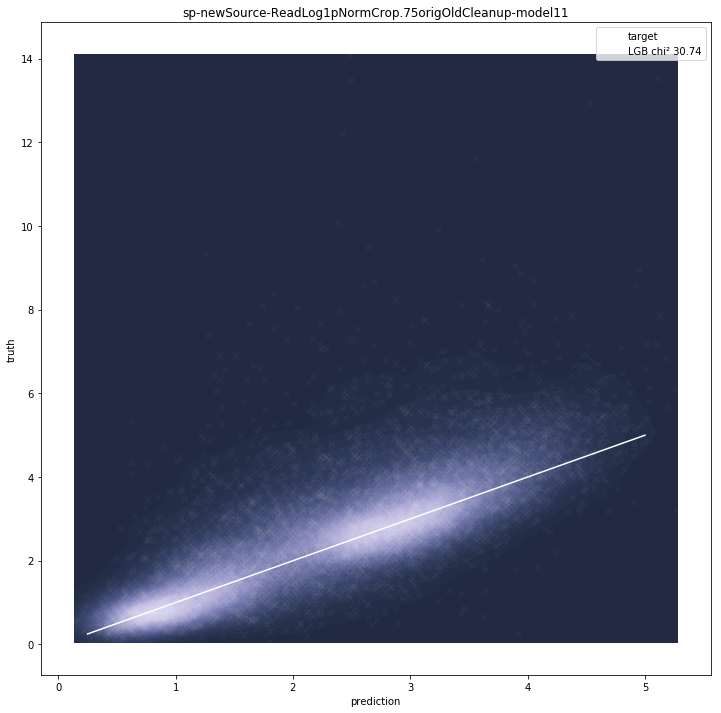

In [52]:
plt.figure(figsize=(12,12))
# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

plt.title(prefixThisRound)
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60,shade_lowest=False, )
sns.kdeplot(cvpred, data[TEST+TRUTH], alpha=0.99, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=cvpred, y=data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, bw=0.2, cut=0, n_levels=20, alpha=0.5)
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()

In [117]:
# Xg3fNames

In [64]:

Xg3fNames.index(prefixThisRound+'.'+'norm.flux.sum')

3068

In [68]:

data[TRAIN+FEATURES][:,Xg3fNames.index(prefixThisRound+'.'+'norm.flux.sum')].shape

(69217,)

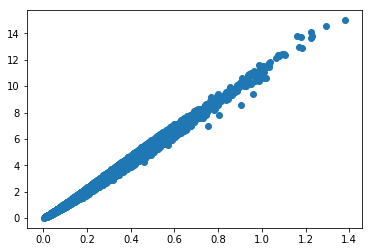

In [99]:
data[TRAIN+TRUTH].shape

plt.scatter(x=df.iloc[:69217].ML_g/df.iloc[:69217].logMstar, y=data[TRAIN+TRUTH])

In [94]:
# list(data[ID][:69217])

In [128]:
#df.iloc[list(data[ID][:69217])]


In [137]:
data[TRAIN+FEATURES]

86537